In [21]:
import os.path as osp
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.backends import cudnn
import random

from configs import *
from face_dataset import *


In [22]:
configs = Configs()
ROOT_DIR = configs.root_dir
image_dir = os.path.join(ROOT_DIR, 'CelebA-HQ-img')

In [23]:
def list_preprocess(image_dir, mask_dir):
    train_dataset = []
    test_dataset = []
    for i in range(len([name for name in os.listdir(image_dir) if osp.isfile(osp.join(image_dir, name))])):
        img_path = osp.join(image_dir, str(i)+'.jpg')
        label_path = osp.join(mask_dir, str(i)+'.png')
        train_dataset.append([img_path, label_path])
    return train_dataset


In [24]:
train_indices = set()
indices_file_pth = os.path.join(ROOT_DIR, 'train.txt')
with open(indices_file_pth, 'r') as file:
    train_indices = set(map(int, file.read().splitlines()))
    
sample_indices = list(range(len(os.listdir(image_dir))))
test_indices = [idx for idx in sample_indices if idx not in train_indices]

# Split indices into training and validation sets
train_indices = list(train_indices)
valid_indices = train_indices
if configs.debug:
    train_indices = train_indices[:100]         
    train_indices, valid_indices = train_test_split(train_indices, test_size=VAL_SIZE, random_state=SEED)
print(len(train_indices))
if configs.debug:
    print(len(valid_indices)) 
print(len(test_indices))

24000
6000


In [25]:

root_dir = configs.root_dir

image_dir = os.path.join(root_dir, 'CelebA-HQ-img')  # Path to image folder
mask_dir = os.path.join(root_dir, 'mask')    # Path to mask folder
train_dataset = list_preprocess(image_dir, mask_dir)
print(len(train_dataset))
# sample_indices = sample_indices

30000


In [26]:
train_dataset = list_preprocess(image_dir, mask_dir)
print(train_dataset[0])


['/home/hsu/HD/CV/CelebAMask-HQ/CelebA-HQ-img/0.jpg', '/home/hsu/HD/CV/CelebAMask-HQ/mask/0.png']


In [27]:
idx_1 = random.randint(0, len(train_indices))
idx_2 = random.randint(1, len(train_indices))
print(idx_1)
print(idx_2)
idx_1 = train_indices[idx_1]
idx_2 = train_indices[idx_2]

img1_pt, img1_mask_pt = train_dataset[idx_1]
img2_pt, img2_mask_pt = train_dataset[idx_2]

# img1 = cv2.imread(img1_pt)
# img1_mask = cv2.imread(img1_mask_pt)
# img2 = cv2.imread(img2_pt)
# img2_mask = cv2.imread(img2_mask_pt)

img1 = Image.open(img1_pt).convert('RGB')
img1 = img1.resize((512, 512), Image.BILINEAR)
img1_mask = Image.open(img1_mask_pt).convert('L')

img2 = Image.open(img2_pt).convert('RGB')
img2 = img2.resize((512, 512), Image.BILINEAR)
img2_mask = Image.open(img2_mask_pt).convert('L')




1658
1213


In [28]:
print(img1_mask.size)
test = np.array(img1_mask)
np.unique(test)

(512, 512)


array([ 0,  1,  2,  3,  4,  5, 10, 11, 12, 13, 16, 17], dtype=uint8)

In [29]:
img1_one_hot_mask = one_hot_encode(np.array(img1_mask), 19)    # (h,w) -> (19, h, w)
img2_one_hot_mask = one_hot_encode(np.array(img2_mask), 19)    # (h,w) -> (19, h, w)
print(np.unique(img1_one_hot_mask[0]))
print(np.unique(img2_one_hot_mask[0]))

img1_bg_mask = img1_one_hot_mask[0]
img2_bg_mask = img2_one_hot_mask[0]
img1_hr_mask = img1_one_hot_mask[17]
img2_hr_mask = img2_one_hot_mask[17]



[0 1]
[0 1]


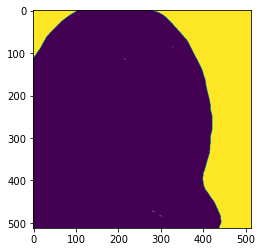

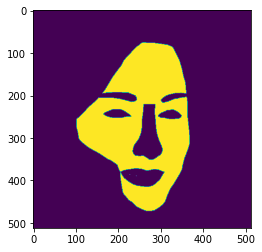

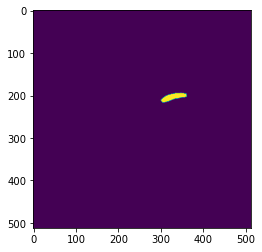

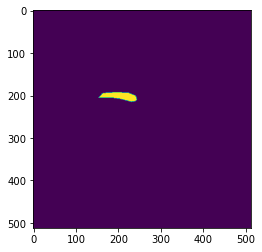

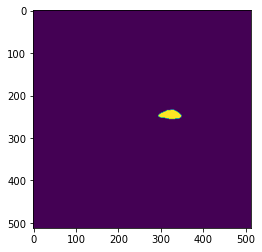

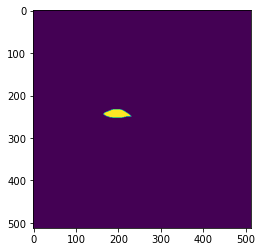

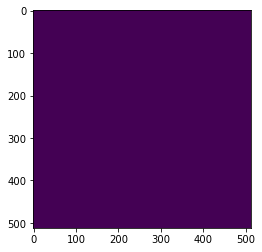

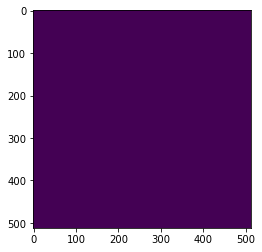

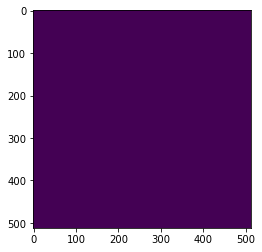

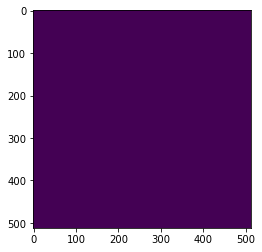

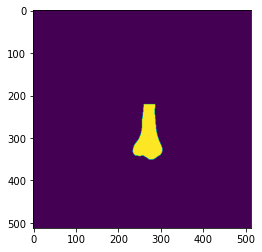

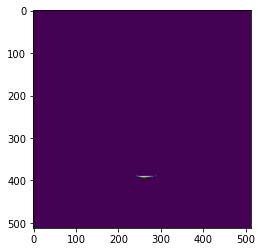

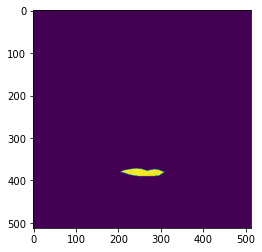

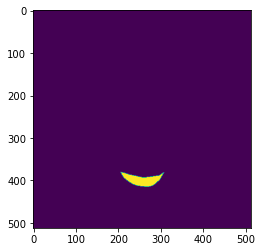

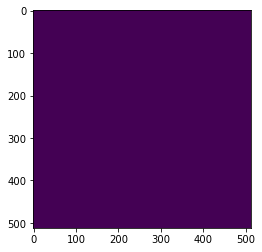

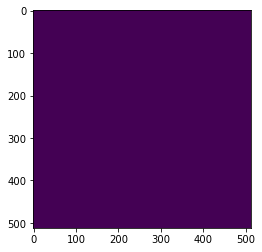

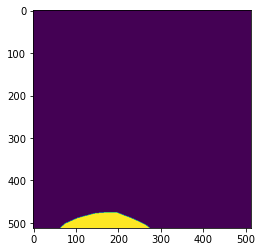

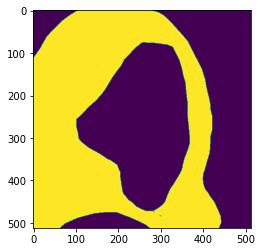

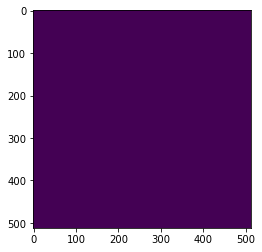

In [30]:
for i in range(19):
    plt.imshow(img1_one_hot_mask[i])
    plt.show()

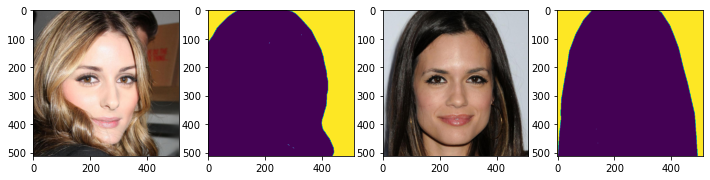

In [31]:
plt.figure(figsize=(12,12))
plt.subplot(1, 4, 1)
plt.imshow(img1)
plt.subplot(1, 4, 2)
plt.imshow(img1_bg_mask)
# plt.imshow(img1_hr_mask)
plt.subplot(1, 4, 3)
plt.imshow(img2)
plt.subplot(1, 4, 4)
# plt.imshow(img2_hr_mask)
plt.imshow(img2_bg_mask)
plt.show()

In [32]:
# def get_mask_from_padded_mask(padded_mask, size=512):
#     start = (padded_mask.shape[0]-size) // 2
#     return padded_mask[start : start+size, start : start+size]

In [33]:
# bigger mask with all 1s outside the mask
# padded_img2_bg_mask = np.pad(img2_bg_mask, ((512, 512), (512, 512)), mode='constant', constant_values=1)
# img2_center_mask = get_mask_from_padded_mask(padded_img2_bg_mask)

# plt.subplot(1, 3, 1)
# plt.imshow(img2_bg_mask)
# plt.subplot(1, 3, 2)
# plt.imshow(padded_img2_bg_mask)
# plt.subplot(1, 3, 3)
# plt.imshow(img2_center_mask)
# plt.show()
# img2_bg_mask
# img2_center_mask.shape

0 327
0 316


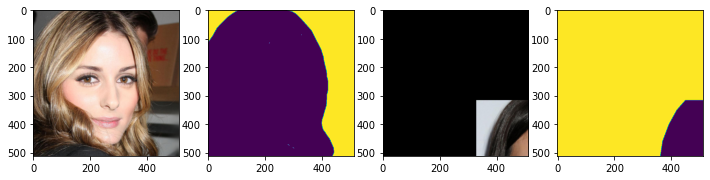

In [34]:
least_hori_shift=300
max_hori_shift=400
least_vert_shift=0
max_vert_shift=350
# Specify the number of pixels to shift
tx = np.random.randint(least_hori_shift, max_hori_shift+1)  # Shift along the x-axis (horizontal)
ty = np.random.randint(least_vert_shift, max_vert_shift+1)  # Shift along the y-axis (vertical)
if random.choice([True, False]):
    tx = -tx
if random.choice([True, False]):
    ty = -ty
# Create the translation matrix

# tx=443 
# ty=61
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])

# Apply the translation using cv2.warpAffine
img2 = np.array(img2)
img1 = np.array(img1)
translated_img2 = cv2.warpAffine(img2, translation_matrix, (img2.shape[1], img2.shape[0]))
translated_img2_bg_mask = cv2.warpAffine(img2_bg_mask, translation_matrix, (img2.shape[1], img2.shape[0]))
translated_img2_hr_mask = cv2.warpAffine(img2_hr_mask, translation_matrix, (img2.shape[1], img2.shape[0]))
# translated_img2_center_mask = get_mask_from_padded_mask(translated_padded_img2_bg_mask)

# fill the edge of the translated mask with 1s
if tx < 0:
    x_start = img2.shape[1] - abs(tx)
    x_end = img2.shape[1]
else:
    x_start = 0
    x_end = tx

if ty < 0:
    y_start = img2.shape[0] - abs(ty)
    y_end = img2.shape[0]
else:
    y_start = 0
    y_end = ty

print(x_start, x_end)
print(y_start, y_end)
translated_img2_bg_mask[:, x_start:x_end] = 1
translated_img2_bg_mask[y_start:y_end, :] = 1
translated_img2_hr_mask[:, x_start:x_end] = 1
translated_img2_hr_mask[y_start:y_end, :] = 1

plt.figure(figsize=(12,12))
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1, 4, 1)
plt.imshow(img1)
plt.subplot(1, 4, 2)
plt.imshow(img1_bg_mask)
plt.subplot(1, 4, 3)
plt.imshow(translated_img2)
# plt.imshow(segmented_image)
plt.subplot(1, 4, 4)
plt.imshow(translated_img2_bg_mask)
# plt.imshow(translated_img2_hr_mask)
# plt.subplot(1, 5, 5)
# plt.imshow(translated_img2_center_mask)
plt.show()

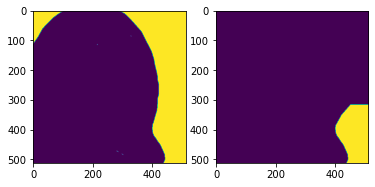

In [35]:
inverted_trans_img2_bg_mask = cv2.bitwise_not(translated_img2_bg_mask)
intersection_mask = cv2.bitwise_and(img1_bg_mask, inverted_trans_img2_bg_mask)
intersection_hr_mask = cv2.bitwise_and(img1_bg_mask, translated_img2_hr_mask)
plt.subplot(1,2,1)
# plt.imshow(inverted_trans_img2_bg_mask)
plt.imshow(img1_bg_mask)
plt.subplot(1,2,2)
plt.imshow(intersection_mask)
# plt.imshow(intersection_hr_mask)
plt.show()


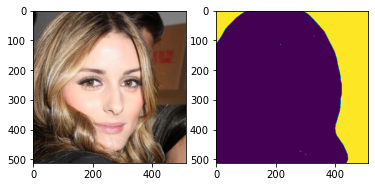

In [36]:
indices = np.where(intersection_mask == 1)
# indices = np.where(intersection_hr_mask == 1)
synth_img = img1.copy()
synth_img[indices] = translated_img2[indices]
plt.subplot(1,2,1)
plt.imshow(synth_img)
plt.subplot(1,2,2)
plt.imshow(img1_bg_mask)
plt.show()

In [37]:
def synthesize_imgs(img1, img1_mask, img2, img2_mask, least_hori_shift=50, max_hori_shift=350,least_vert_shift=50, max_vert_shift=350, ratio=0.15):
    # get the bg mask
    img1_one_hot_mask = one_hot_encode(np.array(img1_mask), 19)    # (h,w) -> (19, h, w)
    img2_one_hot_mask = one_hot_encode(np.array(img2_mask), 19)    # (h,w) -> (19, h, w)
    img1_bg_mask = img1_one_hot_mask[0]
    img2_bg_mask = img2_one_hot_mask[0] 
    img2 = np.array(img2)
    img1 = np.array(img1)
    cnt = 0
    # while True:
    # Specify the number of pixels to shift
    tx = np.random.randint(least_hori_shift, max_hori_shift+1)  # Shift along the x-axis (horizontal)
    ty = np.random.randint(least_vert_shift, max_vert_shift+1)  # Shift along the y-axis (vertical)
    if random.choice([True, False]):
        tx = -tx
    if random.choice([True, False]):
        ty = -ty

    # Create the translation matrix
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    # Apply the translation using cv2.warpAffine
    translated_img2 = cv2.warpAffine(img2, translation_matrix, (img2.shape[1], img2.shape[0]))
    translated_img2_bg_mask = cv2.warpAffine(img2_bg_mask, translation_matrix, (img2.shape[1], img2.shape[0]))

    # fill the edge of the translated mask with 1s
    if tx < 0:
        x_start = img2.shape[1] - abs(tx)
        x_end = img2.shape[1]
    else:
        x_start = 0
        x_end = tx

    if ty < 0:
        y_start = img2.shape[0] - abs(ty)
        y_end = img2.shape[0]
    else:
        y_start = 0
        y_end = ty

    print(x_start, x_end)
    print(y_start, y_end)
    translated_img2_bg_mask[:, x_start:x_end] = 1
    translated_img2_bg_mask[y_start:y_end, :] = 1
    
    inverted_trans_img2_bg_mask = cv2.bitwise_not(translated_img2_bg_mask)
    intersection_mask = cv2.bitwise_and(img1_bg_mask, inverted_trans_img2_bg_mask)
    synth_area = np.sum(intersection_mask)
    total_area = img1.shape[0] * img1.shape[1]
        # if synth_area > total_area*ratio:
        #     break
        # else:
        #     cnt += 1
        # if cnt > 100:
        #     return None, None, None
    plt.imshow(img2)
    plt.show()
    plt.imshow(translated_img2)
    plt.show()
    plt.imshow(translated_img2_bg_mask)
    plt.show()
    plt.imshow(inverted_trans_img2_bg_mask)
    plt.show()
    plt.imshow(intersection_mask)
    plt.show()
    indices = np.where(intersection_mask == 1)
    synth_img = img1.copy()
    synth_img[indices] = translated_img2[indices]
    synth_mask = img1_mask
    synth_bg_mask = img1_bg_mask
    print(tx, ty)
    return synth_img, synth_mask, synth_bg_mask


0 388
348 512


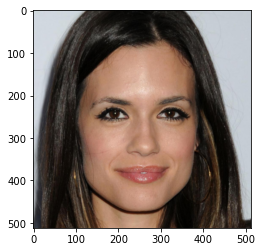

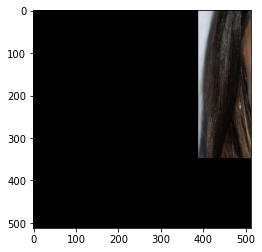

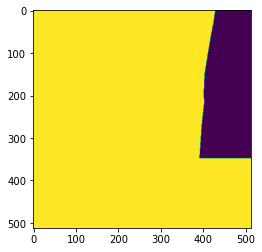

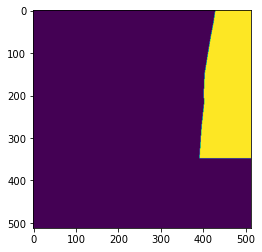

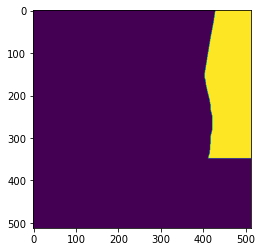

388 -164


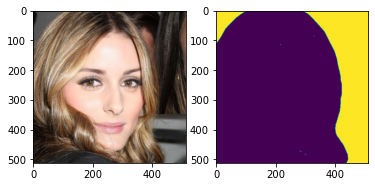

In [38]:
# synth_img, synth_mask, synth_bg_mask = synthesize_imgs(img1, img1_mask, img2, img2_mask, least_shift=50, max_shift=350, ratio=0.1)
synth_img, synth_mask, synth_bg_mask = synthesize_imgs(img1, img1_mask, img2, img2_mask, 
                                                       least_hori_shift=350, max_hori_shift=450,
                                                       least_vert_shift=0, max_vert_shift=350, ratio=0.1)
# synth_img = cv2.cvtColor(synth_img, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,1)
plt.imshow(synth_img)
plt.subplot(1,2,2)
plt.imshow(synth_bg_mask)
plt.show()

In [39]:
synth_img = cv2.cvtColor(synth_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("/home/hsu/HD/CV/face_parsing_mod/test.jpg", synth_img)
synth_mask.save("/home/hsu/HD/CV/face_parsing_mod/test_mask.png")
mask = Image.open("/home/hsu/HD/CV/face_parsing_mod/test_mask.png").convert("L")
print(np.unique(np.array(mask)))

[ 0  1  2  3  4  5 10 11 12 13 16 17]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9600
2400
b_img_size: torch.Size([4, 3, 512, 512])
b_mask_size: torch.Size([4, 512, 512])


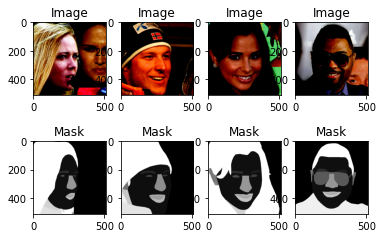

In [40]:
 ROOT_DIR = "/home/hsu/HD/CV/Synth-CelebAMask-HQ/"
 synth_trainset = Synth_CelebAMask_HQ_Dataset(root_dir=ROOT_DIR, 
                                mode='train', 
                                augmentation=None,
                                tr_transform=None)
 
from torch.utils.data import DataLoader

# Define a DataLoader to get batches of samples
dataloader = DataLoader(synth_trainset, batch_size=4, shuffle=True)

# Get a batch of samples
for images, masks in dataloader:
    # Visualize each sample in the batch
    print(f'b_img_size: {images.shape}')
    print(f'b_mask_size: {masks.shape}')
    for i in range(images.shape[0]):
        image = images[i].permute(1, 2, 0).numpy()  # Convert PyTorch tensor to NumPy array and rearrange dimensions
        mask = masks[i].numpy()
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Plot the image and mask side by side
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(2, 4, i + 5)
        plt.imshow(mask, cmap='gray')  # Assuming masks are grayscale
        # plt.imshow(mask)  # Assuming masks are grayscale
        plt.title('Mask')
    plt.show()
    break  # Only visualize the first batch for simplicity

In [41]:
from metrics import *
import os.path as osp
import os
import cv2
import numpy as np
from augmentation import *
from face_dataset import *
from models.unet import *
from models.attention_unet import *
from criterion import *
from tester import *
from configs import *
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.backends import cudnn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import optim
import segmentation_models_pytorch as smp
import gc
from utils import *

configs = Configs()
SEED = configs.seed
cudnn.enabled = True
cudnn.benchmark = True
cudnn.deterministic = False
torch.cuda.manual_seed(SEED)

unseen_dir = "/home/hsu/HD/CV/unseen_10samples"
image_list = []
mask_list = []


### load model weight ###
DEVICE = configs.device
SAVEPATH = configs.model_path
OUTPUT_DIR = f'{configs.cmp_result_dir}/vis_{get_current_timestamp()}'
OUTPUT_DIR_UNSEEN = f'{configs.cmp_result_dir}/unseen_vis_{get_current_timestamp()}'
MODEL_WEIGHT = configs.load_model_weight
exp_setting = "dlv3p_rx101_synth12000_25ep"

if configs.debug:
    MODEL_WEIGHT = 'model_debug.pth'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## make sure the setting is same as the model in train.py
# ENCODER = 'efficientnet-b3'
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'imagenet'
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=19, 
)

print(os.path.join(SAVEPATH , MODEL_WEIGHT))
model = model.cuda()
model.load_state_dict(torch.load(os.path.join(SAVEPATH , MODEL_WEIGHT)))

to_tensor = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])




ROOT_DIR = configs.root_dir
image_dir = os.path.join(ROOT_DIR, 'CelebA-HQ-img')

train_indices = set()
indices_file_pth = os.path.join(ROOT_DIR, 'train.txt')
with open(indices_file_pth, 'r') as file:
    train_indices = set(map(int, file.read().splitlines()))
    
sample_indices = list(range(len(os.listdir(image_dir))))
test_indices = [idx for idx in sample_indices if idx not in train_indices]
# Split indices into training and validation sets
train_indices = list(train_indices)
if configs.debug:
    train_indices = train_indices[:100]         
VAL_SIZE = configs.val_size
train_indices, valid_indices = train_test_split(train_indices, test_size=VAL_SIZE, random_state=SEED)
print(len(test_indices))

test_indices = test_indices[:100]


### test dataloader ###
BATCH_SIZE = configs.batch_size
N_WORKERS = configs.n_workers

testset = CelebAMask_HQ_Dataset(root_dir=ROOT_DIR,
                            sample_indices=test_indices,
                            mode='test')

test_loader = DataLoader(testset,
                    batch_size = 1,
                    shuffle = False,
                    num_workers = N_WORKERS, 
                    pin_memory = True,
                    drop_last = True)

criterion = DiceLoss()
    
Tester(model=model, 
    testloader=test_loader, 
    criterion=criterion, 
    device=DEVICE).run()


for filename in os.listdir(unseen_dir):
    if filename.endswith('.jpg'):
        # Append to the image list if it's a JPG file
        image_list.append(os.path.join(unseen_dir, filename))
    elif filename.endswith('.png'):
        # Append to the mask list if it's a PNG file
        mask_list.append(os.path.join(unseen_dir, filename))
mask_list = sorted(mask_list)
image_list = sorted(image_list)

metrics = SegMetric(n_classes=11)

for i in tqdm(range(0, len(image_list))):
    ### The below operation is simmilar to the __getitem__() function
    # if i != 5: 
    #     continue
    img_pth = image_list[i]
    mask_pth = mask_list[i]
    print(img_pth)
    image = Image.open(img_pth).convert('RGB')
    image = image.resize((512, 512), Image.BILINEAR)
    mask = Image.open(mask_pth).convert('L')
    mask = mask.resize((512, 512), Image.BILINEAR)

    # one_hot_mask = one_hot_encode(np.array(mask), 19)
    # unseen_one_hot_mask = one_hot_mask[:11]
    # unseen_one_hot_mask = one_hot_mask[:, :, [0, 1, 2, 3, 4, 5, 10, 12, 11, 13, 17, 8, 7, 9, 14, 15, 16, 10, 18]]
    # [bg, skin, lb, rb, ley, rey, no, ul, mo, bl, hr]
#    ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
#             'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']


    
    # for i in range(19):
    #     plt.imshow(one_hot_mask[i])
    #     plt.show()


    image = to_tensor(image).unsqueeze(0)
    gt_mask = torch.from_numpy(np.array(mask)).long().unsqueeze(0)
    # print(image.shape)
    # print(np.unique(gt_mask))
    # ### predict with model
    pred_mask = model(image.cuda())     # predict
    print(pred_mask.shape)
    pred_mask = pred_mask[:, [0, 1, 2, 3, 4, 5, 10, 12, 11, 13, 17, 8, 7, 9, 14, 15, 16, 10, 18], :, :]
    pred_mask = pred_mask[:, :11, :, :]
    pred_mask = pred_mask.data.max(1)[1].cpu().numpy()  # Matrix index  (1,19,h,w) => (1,h,w)

    gt_mask = gt_mask.cpu().numpy()
    print(gt_mask.shape)
    print(pred_mask.shape)
    metrics.update(gt_mask, pred_mask)

metric_score = metrics.get_scores()[0]
for k, v in metric_score.items():
    print(k, v)
    
       

../model_weight/model_DLv3p_r50_best_finetune_30eps_2023_12_26_005410.pth


RuntimeError: Error(s) in loading state_dict for DeepLabV3Plus:
	Missing key(s) in state_dict: "encoder.layer3.6.conv1.weight", "encoder.layer3.6.bn1.weight", "encoder.layer3.6.bn1.bias", "encoder.layer3.6.bn1.running_mean", "encoder.layer3.6.bn1.running_var", "encoder.layer3.6.conv2.weight", "encoder.layer3.6.bn2.weight", "encoder.layer3.6.bn2.bias", "encoder.layer3.6.bn2.running_mean", "encoder.layer3.6.bn2.running_var", "encoder.layer3.6.conv3.weight", "encoder.layer3.6.bn3.weight", "encoder.layer3.6.bn3.bias", "encoder.layer3.6.bn3.running_mean", "encoder.layer3.6.bn3.running_var", "encoder.layer3.7.conv1.weight", "encoder.layer3.7.bn1.weight", "encoder.layer3.7.bn1.bias", "encoder.layer3.7.bn1.running_mean", "encoder.layer3.7.bn1.running_var", "encoder.layer3.7.conv2.weight", "encoder.layer3.7.bn2.weight", "encoder.layer3.7.bn2.bias", "encoder.layer3.7.bn2.running_mean", "encoder.layer3.7.bn2.running_var", "encoder.layer3.7.conv3.weight", "encoder.layer3.7.bn3.weight", "encoder.layer3.7.bn3.bias", "encoder.layer3.7.bn3.running_mean", "encoder.layer3.7.bn3.running_var", "encoder.layer3.8.conv1.weight", "encoder.layer3.8.bn1.weight", "encoder.layer3.8.bn1.bias", "encoder.layer3.8.bn1.running_mean", "encoder.layer3.8.bn1.running_var", "encoder.layer3.8.conv2.weight", "encoder.layer3.8.bn2.weight", "encoder.layer3.8.bn2.bias", "encoder.layer3.8.bn2.running_mean", "encoder.layer3.8.bn2.running_var", "encoder.layer3.8.conv3.weight", "encoder.layer3.8.bn3.weight", "encoder.layer3.8.bn3.bias", "encoder.layer3.8.bn3.running_mean", "encoder.layer3.8.bn3.running_var", "encoder.layer3.9.conv1.weight", "encoder.layer3.9.bn1.weight", "encoder.layer3.9.bn1.bias", "encoder.layer3.9.bn1.running_mean", "encoder.layer3.9.bn1.running_var", "encoder.layer3.9.conv2.weight", "encoder.layer3.9.bn2.weight", "encoder.layer3.9.bn2.bias", "encoder.layer3.9.bn2.running_mean", "encoder.layer3.9.bn2.running_var", "encoder.layer3.9.conv3.weight", "encoder.layer3.9.bn3.weight", "encoder.layer3.9.bn3.bias", "encoder.layer3.9.bn3.running_mean", "encoder.layer3.9.bn3.running_var", "encoder.layer3.10.conv1.weight", "encoder.layer3.10.bn1.weight", "encoder.layer3.10.bn1.bias", "encoder.layer3.10.bn1.running_mean", "encoder.layer3.10.bn1.running_var", "encoder.layer3.10.conv2.weight", "encoder.layer3.10.bn2.weight", "encoder.layer3.10.bn2.bias", "encoder.layer3.10.bn2.running_mean", "encoder.layer3.10.bn2.running_var", "encoder.layer3.10.conv3.weight", "encoder.layer3.10.bn3.weight", "encoder.layer3.10.bn3.bias", "encoder.layer3.10.bn3.running_mean", "encoder.layer3.10.bn3.running_var", "encoder.layer3.11.conv1.weight", "encoder.layer3.11.bn1.weight", "encoder.layer3.11.bn1.bias", "encoder.layer3.11.bn1.running_mean", "encoder.layer3.11.bn1.running_var", "encoder.layer3.11.conv2.weight", "encoder.layer3.11.bn2.weight", "encoder.layer3.11.bn2.bias", "encoder.layer3.11.bn2.running_mean", "encoder.layer3.11.bn2.running_var", "encoder.layer3.11.conv3.weight", "encoder.layer3.11.bn3.weight", "encoder.layer3.11.bn3.bias", "encoder.layer3.11.bn3.running_mean", "encoder.layer3.11.bn3.running_var", "encoder.layer3.12.conv1.weight", "encoder.layer3.12.bn1.weight", "encoder.layer3.12.bn1.bias", "encoder.layer3.12.bn1.running_mean", "encoder.layer3.12.bn1.running_var", "encoder.layer3.12.conv2.weight", "encoder.layer3.12.bn2.weight", "encoder.layer3.12.bn2.bias", "encoder.layer3.12.bn2.running_mean", "encoder.layer3.12.bn2.running_var", "encoder.layer3.12.conv3.weight", "encoder.layer3.12.bn3.weight", "encoder.layer3.12.bn3.bias", "encoder.layer3.12.bn3.running_mean", "encoder.layer3.12.bn3.running_var", "encoder.layer3.13.conv1.weight", "encoder.layer3.13.bn1.weight", "encoder.layer3.13.bn1.bias", "encoder.layer3.13.bn1.running_mean", "encoder.layer3.13.bn1.running_var", "encoder.layer3.13.conv2.weight", "encoder.layer3.13.bn2.weight", "encoder.layer3.13.bn2.bias", "encoder.layer3.13.bn2.running_mean", "encoder.layer3.13.bn2.running_var", "encoder.layer3.13.conv3.weight", "encoder.layer3.13.bn3.weight", "encoder.layer3.13.bn3.bias", "encoder.layer3.13.bn3.running_mean", "encoder.layer3.13.bn3.running_var", "encoder.layer3.14.conv1.weight", "encoder.layer3.14.bn1.weight", "encoder.layer3.14.bn1.bias", "encoder.layer3.14.bn1.running_mean", "encoder.layer3.14.bn1.running_var", "encoder.layer3.14.conv2.weight", "encoder.layer3.14.bn2.weight", "encoder.layer3.14.bn2.bias", "encoder.layer3.14.bn2.running_mean", "encoder.layer3.14.bn2.running_var", "encoder.layer3.14.conv3.weight", "encoder.layer3.14.bn3.weight", "encoder.layer3.14.bn3.bias", "encoder.layer3.14.bn3.running_mean", "encoder.layer3.14.bn3.running_var", "encoder.layer3.15.conv1.weight", "encoder.layer3.15.bn1.weight", "encoder.layer3.15.bn1.bias", "encoder.layer3.15.bn1.running_mean", "encoder.layer3.15.bn1.running_var", "encoder.layer3.15.conv2.weight", "encoder.layer3.15.bn2.weight", "encoder.layer3.15.bn2.bias", "encoder.layer3.15.bn2.running_mean", "encoder.layer3.15.bn2.running_var", "encoder.layer3.15.conv3.weight", "encoder.layer3.15.bn3.weight", "encoder.layer3.15.bn3.bias", "encoder.layer3.15.bn3.running_mean", "encoder.layer3.15.bn3.running_var", "encoder.layer3.16.conv1.weight", "encoder.layer3.16.bn1.weight", "encoder.layer3.16.bn1.bias", "encoder.layer3.16.bn1.running_mean", "encoder.layer3.16.bn1.running_var", "encoder.layer3.16.conv2.weight", "encoder.layer3.16.bn2.weight", "encoder.layer3.16.bn2.bias", "encoder.layer3.16.bn2.running_mean", "encoder.layer3.16.bn2.running_var", "encoder.layer3.16.conv3.weight", "encoder.layer3.16.bn3.weight", "encoder.layer3.16.bn3.bias", "encoder.layer3.16.bn3.running_mean", "encoder.layer3.16.bn3.running_var", "encoder.layer3.17.conv1.weight", "encoder.layer3.17.bn1.weight", "encoder.layer3.17.bn1.bias", "encoder.layer3.17.bn1.running_mean", "encoder.layer3.17.bn1.running_var", "encoder.layer3.17.conv2.weight", "encoder.layer3.17.bn2.weight", "encoder.layer3.17.bn2.bias", "encoder.layer3.17.bn2.running_mean", "encoder.layer3.17.bn2.running_var", "encoder.layer3.17.conv3.weight", "encoder.layer3.17.bn3.weight", "encoder.layer3.17.bn3.bias", "encoder.layer3.17.bn3.running_mean", "encoder.layer3.17.bn3.running_var", "encoder.layer3.18.conv1.weight", "encoder.layer3.18.bn1.weight", "encoder.layer3.18.bn1.bias", "encoder.layer3.18.bn1.running_mean", "encoder.layer3.18.bn1.running_var", "encoder.layer3.18.conv2.weight", "encoder.layer3.18.bn2.weight", "encoder.layer3.18.bn2.bias", "encoder.layer3.18.bn2.running_mean", "encoder.layer3.18.bn2.running_var", "encoder.layer3.18.conv3.weight", "encoder.layer3.18.bn3.weight", "encoder.layer3.18.bn3.bias", "encoder.layer3.18.bn3.running_mean", "encoder.layer3.18.bn3.running_var", "encoder.layer3.19.conv1.weight", "encoder.layer3.19.bn1.weight", "encoder.layer3.19.bn1.bias", "encoder.layer3.19.bn1.running_mean", "encoder.layer3.19.bn1.running_var", "encoder.layer3.19.conv2.weight", "encoder.layer3.19.bn2.weight", "encoder.layer3.19.bn2.bias", "encoder.layer3.19.bn2.running_mean", "encoder.layer3.19.bn2.running_var", "encoder.layer3.19.conv3.weight", "encoder.layer3.19.bn3.weight", "encoder.layer3.19.bn3.bias", "encoder.layer3.19.bn3.running_mean", "encoder.layer3.19.bn3.running_var", "encoder.layer3.20.conv1.weight", "encoder.layer3.20.bn1.weight", "encoder.layer3.20.bn1.bias", "encoder.layer3.20.bn1.running_mean", "encoder.layer3.20.bn1.running_var", "encoder.layer3.20.conv2.weight", "encoder.layer3.20.bn2.weight", "encoder.layer3.20.bn2.bias", "encoder.layer3.20.bn2.running_mean", "encoder.layer3.20.bn2.running_var", "encoder.layer3.20.conv3.weight", "encoder.layer3.20.bn3.weight", "encoder.layer3.20.bn3.bias", "encoder.layer3.20.bn3.running_mean", "encoder.layer3.20.bn3.running_var", "encoder.layer3.21.conv1.weight", "encoder.layer3.21.bn1.weight", "encoder.layer3.21.bn1.bias", "encoder.layer3.21.bn1.running_mean", "encoder.layer3.21.bn1.running_var", "encoder.layer3.21.conv2.weight", "encoder.layer3.21.bn2.weight", "encoder.layer3.21.bn2.bias", "encoder.layer3.21.bn2.running_mean", "encoder.layer3.21.bn2.running_var", "encoder.layer3.21.conv3.weight", "encoder.layer3.21.bn3.weight", "encoder.layer3.21.bn3.bias", "encoder.layer3.21.bn3.running_mean", "encoder.layer3.21.bn3.running_var", "encoder.layer3.22.conv1.weight", "encoder.layer3.22.bn1.weight", "encoder.layer3.22.bn1.bias", "encoder.layer3.22.bn1.running_mean", "encoder.layer3.22.bn1.running_var", "encoder.layer3.22.conv2.weight", "encoder.layer3.22.bn2.weight", "encoder.layer3.22.bn2.bias", "encoder.layer3.22.bn2.running_mean", "encoder.layer3.22.bn2.running_var", "encoder.layer3.22.conv3.weight", "encoder.layer3.22.bn3.weight", "encoder.layer3.22.bn3.bias", "encoder.layer3.22.bn3.running_mean", "encoder.layer3.22.bn3.running_var". 
	size mismatch for encoder.layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 64, 1, 1]).
	size mismatch for encoder.layer1.0.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for encoder.layer1.0.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.0.conv3.weight: copying a param with shape torch.Size([256, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for encoder.layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for encoder.layer1.1.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for encoder.layer1.1.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.1.conv3.weight: copying a param with shape torch.Size([256, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for encoder.layer1.2.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for encoder.layer1.2.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for encoder.layer1.2.bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer1.2.conv3.weight: copying a param with shape torch.Size([256, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for encoder.layer2.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for encoder.layer2.0.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for encoder.layer2.0.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.0.conv3.weight: copying a param with shape torch.Size([512, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for encoder.layer2.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for encoder.layer2.1.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for encoder.layer2.1.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.1.conv3.weight: copying a param with shape torch.Size([512, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for encoder.layer2.2.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for encoder.layer2.2.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for encoder.layer2.2.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.2.conv3.weight: copying a param with shape torch.Size([512, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for encoder.layer2.3.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for encoder.layer2.3.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for encoder.layer2.3.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer2.3.conv3.weight: copying a param with shape torch.Size([512, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for encoder.layer3.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 512, 1, 1]).
	size mismatch for encoder.layer3.0.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for encoder.layer3.0.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.0.conv3.weight: copying a param with shape torch.Size([1024, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.1.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for encoder.layer3.1.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.1.conv3.weight: copying a param with shape torch.Size([1024, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.2.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.2.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for encoder.layer3.2.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.2.conv3.weight: copying a param with shape torch.Size([1024, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.3.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.3.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for encoder.layer3.3.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.3.conv3.weight: copying a param with shape torch.Size([1024, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.4.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.4.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for encoder.layer3.4.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.4.conv3.weight: copying a param with shape torch.Size([1024, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.5.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer3.5.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.conv2.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for encoder.layer3.5.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layer3.5.conv3.weight: copying a param with shape torch.Size([1024, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for encoder.layer4.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for encoder.layer4.0.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.conv2.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 64, 3, 3]).
	size mismatch for encoder.layer4.0.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.0.conv3.weight: copying a param with shape torch.Size([2048, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for encoder.layer4.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for encoder.layer4.1.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.conv2.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 64, 3, 3]).
	size mismatch for encoder.layer4.1.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.1.conv3.weight: copying a param with shape torch.Size([2048, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for encoder.layer4.2.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for encoder.layer4.2.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.conv2.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 64, 3, 3]).
	size mismatch for encoder.layer4.2.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layer4.2.conv3.weight: copying a param with shape torch.Size([2048, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).

(512, 512, 3) (512, 512)


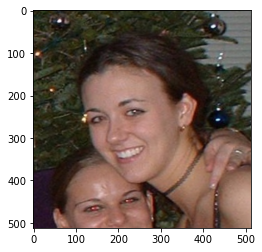

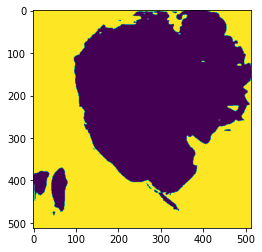

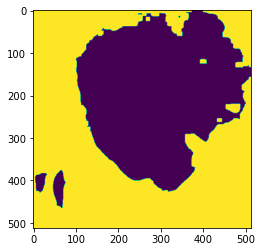

NameError: name 'box' is not defined

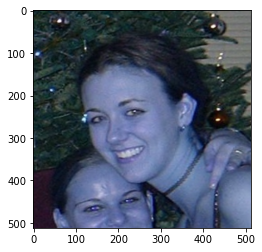

In [23]:
import cv2
import numpy as np
from retinaface import RetinaFace
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# Load the image
img = cv2.imread('/home/hsu/HD/CV/unseen_10samples/11338398_3.jpg')
img = cv2.resize(img, (512, 512), cv2.INTER_LINEAR)
predicted_mask = cv2.imread('/home/hsu/HD/CV/face_parsing_mod/result/unseen_10_dlv3p_rx101_synth12000_test_result_2023_12_27_031015/Test-image-2/background.png', cv2.IMREAD_GRAYSCALE)
# Create a mask initialized with zeros
# mask = np.zeros(img.shape[:2], np.uint8)
print(img.shape, predicted_mask.shape)
def refine_segmentation(image, initial_mask):
    # Create a mask initialized with the predicted mask
    mask = initial_mask.copy()
    binary_mask = np.where(mask > 0, cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype(np.uint8)

    # Initialize background and foreground models with zeros
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Run GrabCut with mask initialization
    cv2.grabCut(image, binary_mask, None, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_MASK)

    # Modify the mask to create a binary mask for the refined foreground
    refined_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    return refined_mask

# Refine the segmentation using GrabCut
# refined_mask = refine_segmentation(img, predicted_mask)

refined_mask = cv2.dilate(predicted_mask, kernel=np.ones((5, 5), np.uint8), iterations=2)
# refined_mask = cv2.erode(predicted_mask, kernel=np.ones((2, 2), np.uint8), iterations=3)

# Apply the refined mask to the original image
result = img * refined_mask[:, :, np.newaxis]

# Display the result
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1)
ax.imshow(img)
fig, ax = plt.subplots(1)
ax.imshow(predicted_mask)
plt.show()
plt.show()
fig, ax = plt.subplots(1)
ax.imshow(refined_mask)
plt.show()
# Define a rectangle around the object of interest
# resp = RetinaFace.detect_faces(img)
# print(resp)
# box = resp['face_1']['facial_area']
# print(box)

# width = box[2]-box[0]
# height = box[3]-box[1]

# x = (box[2]+box[0]) // 2
# y = (box[3]+box[1]) // 2

# rect = (x, y, width+150, height+150)

# # Initialize background and foreground models with zeros
# bgdModel = np.zeros((1, 65), np.float64)
# fgdModel = np.zeros((1, 65), np.float64)

# # Run GrabCut with rectangle initialization
# cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# # Modify the mask to create a binary mask for the refined foreground
# result_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# # Apply the mask to the original image
# result = img * result_mask[:, :, np.newaxis]

# Display the result
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                         linewidth=2, edgecolor='g', facecolor='none')
ax.scatter(x, y, c='b')
ax.add_patch(rect)

# Set axis limits based on the bounding box
# ax.set_xlim(box[0] - 10, box[2] + 10)
# ax.set_ylim(box[3] + 10, box[1] - 10)  # y-axis is inverted in images
plt.show()
plt.imshow(result)
plt.show()

In [ ]:

import cv2
import numpy as np
from retinaface import RetinaFace
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def scale_box(box,scale):
    dx = box[2]-box[0];dy = box[3]-box[1]
    newbox = [int(box[0]-dx*(scale/2)),int(box[1]-dy*(scale/2)),int(box[2]+dx*(scale/2)),int(box[3]+dy*(scale/2))]
    return newbox

def bbox_crop(img, bbox ,rate_w):
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    center_x = (box[2]+box[0]) // 2
    center_y = (box[3]+box[1]) // 2
    img_size = img.shape[0]
    new_width = width * (1 + rate_w)
    new_height =  img_size 

    tl_corner_x = center_x - new_width//2
    br_corner_x = center_x + new_width//2
    if br_corner_x > img_size:
        br_corner_x = img_size
    if tl_corner_x < 0:
        tl_corner_x = 0

    img[tl_corner_x:, :] = 0
    img[:br_corner_x, :] = 0

    return img

    




img = cv2.imread('/home/hsu/HD/CV/unseen_10samples/11338398_3.jpg')
img = cv2.resize(img, (512, 512), cv2.INTER_LINEAR)


resp = RetinaFace.detect_faces(image)
box = resp['face_1']['facial_area']
# corner1 = [int(box[0]) ,int(box[1])]
# corner2 = [int(box[2]), int(box[3])]
# mask[:, :corner1[0]] = 0
# mask[:, corner2[0]:] = 0
# mask[corner2[1]:, :] = 0
# mask[:corner1[1], :] = 0


# img = Image.open(image_list[index])
# img = np.array(img)
# img = cv2.resize(img,(512,512))
# resp = RetinaFace.detect_faces(img)
# box = resp['face_1']['facial_area']
# face_center = [(box[0]+box[2])/2,(box[1]+box[3])/2]
# # print(face_center)
# translation_matrix = np.float32([[1,0,256-int(face_center[0])], [0,1,256-int(face_center[1])]])
# translated_img = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
# translated_mask = cv2.warpAffine(mask19[index], translation_matrix, (mask.shape[1], mask.shape[0]))

